In [24]:
# Imports
# External imports
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Module imports
import biological_fuzzy_logic_networks.biofuzznet as bfn
import biological_fuzzy_logic_networks.utils as utils
import biological_fuzzy_logic_networks.draw as draw
from biological_fuzzy_logic_networks.DREAM.DREAMBioFuzzNet import DREAMBioFuzzNet
from biological_fuzzy_logic_networks.DREAM.DREAMdataset import DREAMBioFuzzDataset



In [25]:
cl_data = pd.read_csv("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/ZR7530.csv")
non_marker_cols = ["treatment", "cell_line", "time", "cellID", "fileID"]
markers = [c for c in cl_data.columns if not c in non_marker_cols]

cl_data = cl_data[cl_data["time"]==9]
scaler = MinMaxScaler()
cl_data[markers] = scaler.fit_transform(cl_data[markers])
cl_data

,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
25595,EGF,ZR7530,9.0,1,1011,0.395636,0.402194,0.000000,0.492295,0.104349,...,0.375356,0.352125,0.099567,0.273289,0.369775,0.186604,0.383592,0.328056,0.441879,0.340322
25596,EGF,ZR7530,9.0,2,1011,0.000000,0.140044,0.537944,0.409615,0.897755,...,0.000000,0.082241,0.598982,0.378096,0.109032,0.478256,0.245605,0.355943,0.169588,0.300694
25597,EGF,ZR7530,9.0,3,1011,0.279084,0.432673,0.000000,0.713174,0.253652,...,0.210846,0.104309,0.303606,0.395779,0.563735,0.486540,0.255902,0.368843,0.457316,0.304705
25598,EGF,ZR7530,9.0,4,1011,0.000000,0.267420,0.141758,0.430330,0.000000,...,0.020738,0.449832,0.000000,0.453254,0.726091,0.000000,0.398669,0.446374,0.232850,0.345303
25599,EGF,ZR7530,9.0,5,1011,0.530664,0.402922,0.262447,0.677272,0.679108,...,0.590596,0.658284,0.828589,0.609928,0.596778,0.634626,0.410794,0.434798,0.531388,0.382133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438604,iPKC,ZR7530,9.0,8364,981,0.605812,0.292460,0.141792,0.563163,0.029755,...,0.436423,0.599954,0.152836,0.384682,0.554484,0.375520,0.454312,0.329122,0.651206,0.379009
438605,iPKC,ZR7530,9.0,8365,981,0.000000,0.000000,0.131784,0.369437,0.158079,...,0.000000,0.287432,0.000000,0.353103,0.277070,0.445072,0.132246,0.303992,0.311794,0.383396
438606,iPKC,ZR7530,9.0,8366,981,0.584230,0.312458,0.727297,0.552922,0.429372,...,0.501491,0.559899,0.748482,0.391360,0.604408,0.340593,0.354785,0.456384,0.446863,0.387726
438607,iPKC,ZR7530,9.0,8367,981,0.125551,0.480262,0.115179,0.736958,0.172115,...,0.422837,0.738014,0.231625,0.356163,0.653604,0.737798,0.315952,0.361219,0.413430,0.336527


In [26]:
markers = ['p.MEK', 'p.ERK', 'p.p90RSK', 'p.CREB', 'p.PDPK1']

sel_data = cl_data.loc[(cl_data["treatment"].isin(["EGF", "iMEK"])),:][["treatment"]+markers]
sel_data.reset_index(drop=True, inplace=True)
sel_data.loc[sel_data["p.PDPK1"]==0, "p.PDPK1"] = 1e-9
sel_data.loc[sel_data["treatment"]=="iMEK","inhibitor"] = ["p.MEK"  for treatment in sel_data["treatment"] if treatment == "iMEK"]
sel_data.drop("treatment", axis=1, inplace=True)
sel_data

,p.MEK,p.ERK,p.p90RSK,p.CREB,p.PDPK1,inhibitor
0,0.367667,0.330656,0.572618,2.961296e-01,3.753564e-01,NaN
1,0.463700,0.241769,0.529345,1.611169e-07,1.000000e-09,NaN
2,0.394335,0.388390,0.513064,2.144081e-01,2.108456e-01,NaN
3,0.442553,0.407983,0.839117,2.696125e-01,2.073780e-02,NaN
4,0.491981,0.438286,0.831320,3.145570e-01,5.905963e-01,NaN
...,...,...,...,...,...,...
21602,0.511885,0.310768,0.511205,3.188268e-01,2.740522e-01,p.MEK
21603,0.363326,0.156438,0.485483,2.074573e-01,1.569565e-01,p.MEK
21604,0.426858,0.293860,0.432892,4.833507e-07,1.721914e-01,p.MEK
21605,0.500504,0.323495,0.657558,9.054608e-03,4.939004e-01,p.MEK


In [28]:
type(sel_data.loc[0,"inhibitor"])

float

In [4]:
train, test = train_test_split(sel_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train_data = {k: torch.DoubleTensor(v) for k, v in train.items() if k in markers}
test_data = {k: torch.DoubleTensor(v) for k, v in test.items() if k in markers}

train_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in train["inhibitor"]]) for m1 in markers}
test_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in test["inhibitor"]]) for m1 in markers}

input_train = {"p.PDPK1": train["p.PDPK1"]}
input_test = {"p.PDPK1": test["p.PDPK1"]} 




(16205, 6)
(5402, 6)


In [5]:
ds = DREAMBioFuzzDataset(input_train, train_data, train_inhibitors)
dl = torch.utils.data.DataLoader(ds, batch_size=200, shuffle=True)

In [6]:
for X_batch, y_batch, inhibited_batch in dl:
                # In this case we do not use X_batch explicitly, as we just need the ground truth state of each node.
                # Reinitialise the network at the right size
                batch_keys = list(X_batch.keys())
                

In [7]:
X_batch

{'p.PDPK1': tensor([2.7928e-01, 1.0000e-09, 3.0669e-01, 5.5893e-01, 5.6079e-01])}

In [8]:
y_batch

{'p.MEK': tensor([0.2728, 0.1378, 0.3724, 0.4207, 0.4779]),
 'p.ERK': tensor([0.3170, 0.2144, 0.1701, 0.3753, 0.3376]),
 'p.p90RSK': tensor([0.6499, 0.3372, 0.5194, 0.7992, 0.6241]),
 'p.CREB': tensor([0.0867, 0.0335, 0.2005, 0.2148, 0.2071]),
 'p.PDPK1': tensor([2.7928e-01, 1.0000e-09, 3.0669e-01, 5.5893e-01, 5.6079e-01])}

In [9]:
inhibited_batch

{'p.MEK': tensor([ 1.,  1., 10.,  1., 10.]),
 'p.ERK': tensor([1., 1., 1., 1., 1.]),
 'p.p90RSK': tensor([1., 1., 1., 1., 1.]),
 'p.CREB': tensor([1., 1., 1., 1., 1.]),
 'p.PDPK1': tensor([1., 1., 1., 1., 1.])}

In [11]:
# Create an empty BioFuzzNet
my_model = DREAMBioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MEK", "BIO") # A biological node
my_model.add_fuzzy_node("p.ERK", 'BIO')
my_model.add_fuzzy_node("p.p90RSK", "BIO")
my_model.add_fuzzy_node("p.CREB", "BIO")
my_model.add_fuzzy_node("p.PDPK1", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MEK")
my_model.add_transfer_edge("p.PDPK1", "p.MEK")
my_model.add_transfer_edge("p.MEK","p.ERK") 
my_model.add_transfer_edge("p.ERK", "p.p90RSK")
my_model.add_transfer_edge("p.p90RSK", "p.CREB")

{'p.PDPK1': array([ 0., -2.]),
 'p.MEK': array([ 0., -1.]),
 'p.ERK': array([0., 0.]),
 'p.p90RSK': array([0., 1.]),
 'p.CREB': array([0., 2.])}

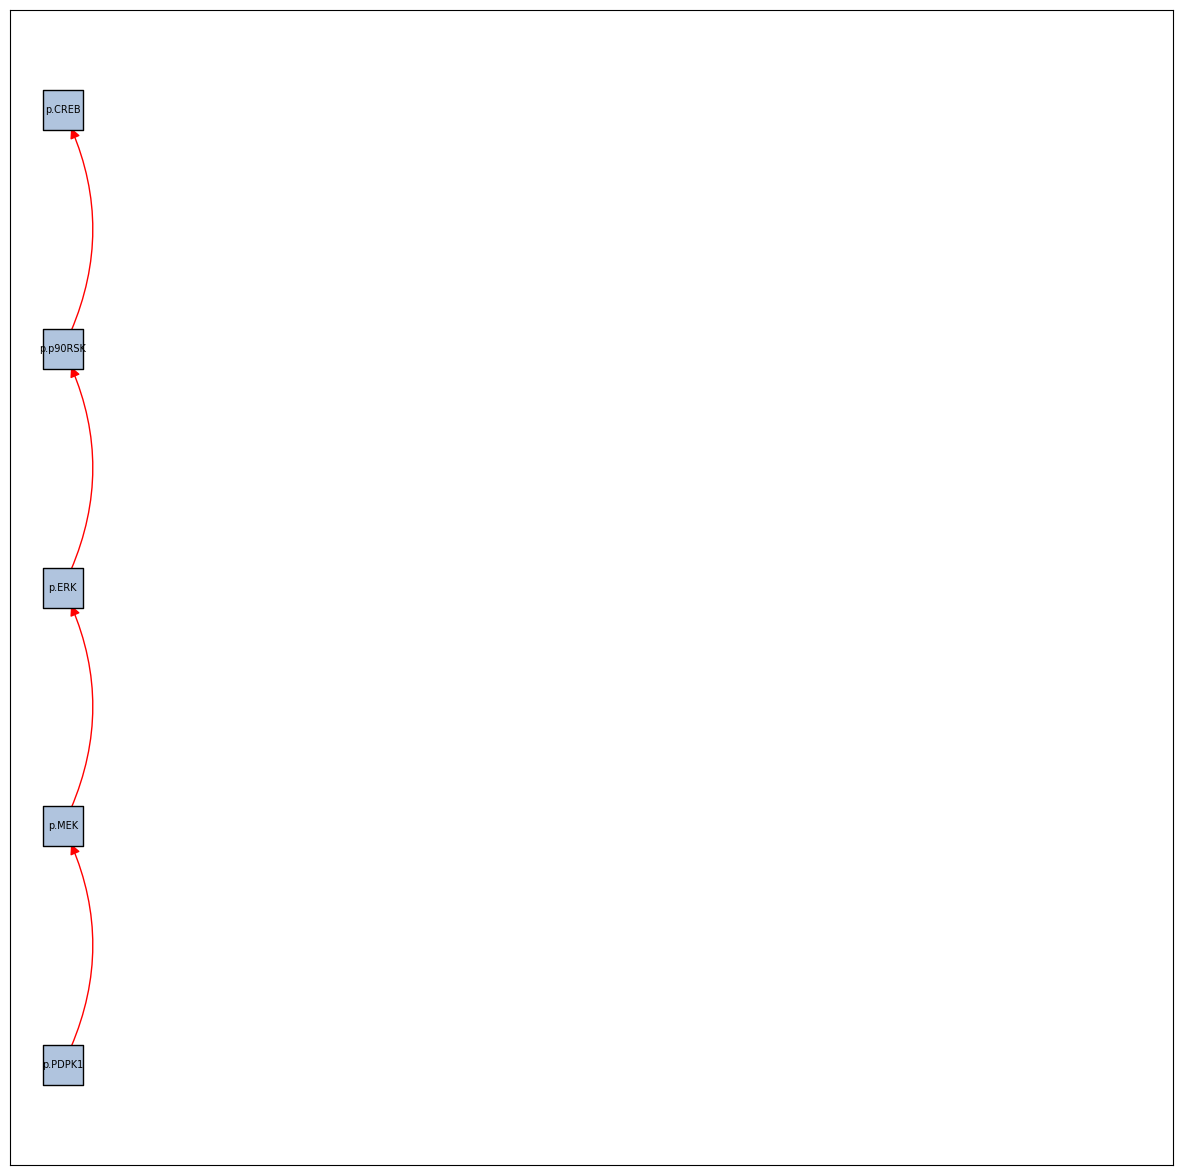

In [12]:
# Draw the networks to compare them
# Color schemes for the drawing
general_edge_color_scheme  = {"simple": "b", "transfer_function": "r"}
general_node_shape_scheme = {"biological": 's', "logic_gate_AND": 'o', 
                             "logic_gate_OR": 'd', "logic_gate_NOT": '^'}

draw.draw_BioFuzzNet(my_model, general_edge_color_scheme, general_node_shape_scheme)  

In [13]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 1 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 10

In [14]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train_data,
                                     test_ground_truth=test_data,
                                     train_inhibitors = train_inhibitors,
                                     test_inhibitors = test_inhibitors,
                                     epochs = epochs,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.10s/it]


<AxesSubplot: xlabel='time', ylabel='loss'>

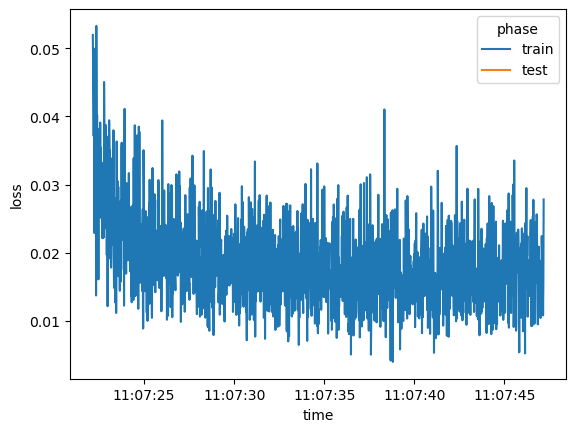

In [15]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')


# Leave treatment with inhibition out

In [16]:
all_treatments = ['EGF', 'full', 'iEGFR', 'iMEK', 'iPI3K', 'iPKC']
test_treatments = ['iMEK']
train_treatments = [treatment for treatment in all_treatments if not treatment in test_treatments]

markers = ['p.MEK', 'p.ERK', 'p.p90RSK', 'p.CREB', 'p.PDPK1']
cl_data.loc[cl_data["p.PDPK1"]==0, "p.PDPK1"] = 1e-9
train_data = cl_data.loc[(cl_data["treatment"].isin(train_treatments)), ['treatment']+markers]
test_data = cl_data.loc[(cl_data["treatment"].isin(test_treatments)), ['treatment']+markers]

train_data.loc[train_data["treatment"]=="iMEK","inhibitor"] = ["p.MEK"  for treatment in train_data["treatment"] if treatment == "iMEK"]
train_data.drop("treatment", axis=1, inplace=True)

test_data.loc[test_data["treatment"]=="iMEK","inhibitor"] = ["p.MEK"  for treatment in test_data["treatment"] if treatment == "iMEK"]
test_data.drop("treatment", axis=1, inplace=True)

n_test = len(test)

train, val = train_test_split(train_data)
print(train.shape)
print(val.shape)

train = train.to_dict("list")
val = val.to_dict("list")
test = test_data.to_dict("list")

train_data = {k: torch.DoubleTensor(v) for k, v in train.items() if k in markers}
test_data = {k: torch.DoubleTensor(v) for k, v in test.items() if k in markers}
val_data = {k: torch.DoubleTensor(v) for k, v in val.items() if k in markers}

train_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in train["inhibitor"]]) for m1 in markers}
test_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in test["inhibitor"]]) for m1 in markers}
val_inhibitors = {m1: torch.DoubleTensor([10. if m==m1 else 1. for m in val["inhibitor"]]) for m1 in markers}

input_train = {"p.PDPK1": train["p.PDPK1"]}
input_test = {"p.PDPK1": test["p.PDPK1"]} 
input_val = {"p.PDPK1": val["p.PDPK1"]} 


(39543, 6)
(13181, 6)


In [17]:
# Create an empty BioFuzzNet
my_model = DREAMBioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MEK", "BIO") # A biological node
my_model.add_fuzzy_node("p.ERK", 'BIO')
my_model.add_fuzzy_node("p.p90RSK", "BIO")
my_model.add_fuzzy_node("p.CREB", "BIO")
my_model.add_fuzzy_node("p.PDPK1", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MEK")
my_model.add_transfer_edge("p.PDPK1", "p.MEK")
my_model.add_transfer_edge("p.MEK","p.ERK") 
my_model.add_transfer_edge("p.ERK", "p.p90RSK")
my_model.add_transfer_edge("p.p90RSK", "p.CREB")

{'p.PDPK1': array([ 0., -2.]),
 'p.MEK': array([ 0., -1.]),
 'p.ERK': array([0., 0.]),
 'p.p90RSK': array([0., 1.]),
 'p.CREB': array([0., 2.])}

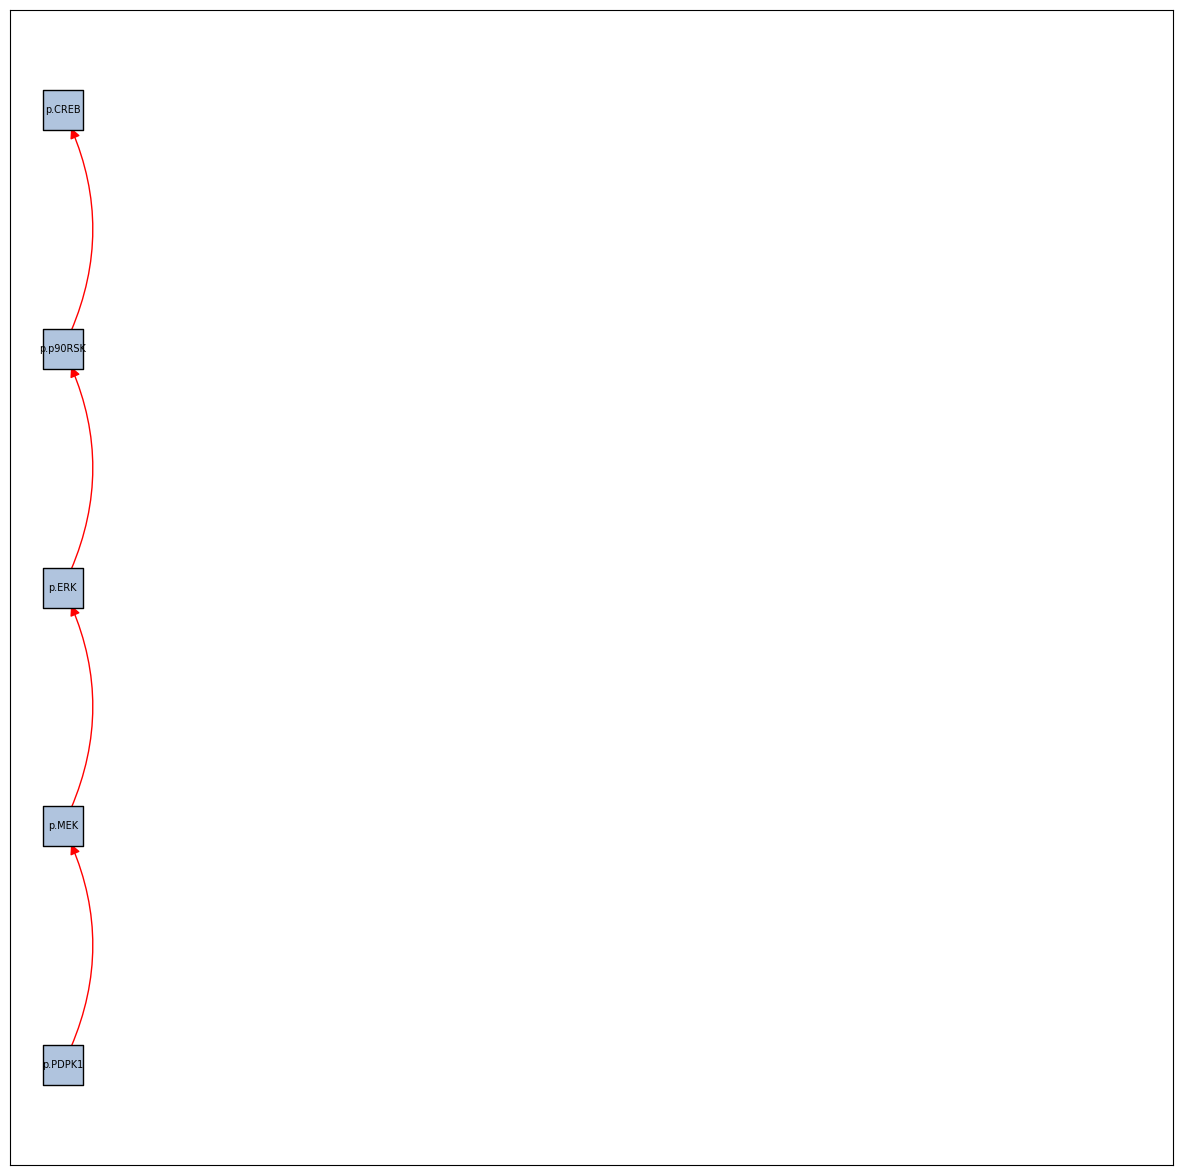

In [18]:
draw.draw_BioFuzzNet(my_model, general_edge_color_scheme, general_node_shape_scheme)  

In [19]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 1
batch_size = 10 

In [20]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_val,
                                     ground_truth=train_data,
                                     test_ground_truth=val_data,
                                     train_inhibitors = train_inhibitors,
                                     test_inhibitors = val_inhibitors,
                                     epochs = epochs,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.23s/it]


<AxesSubplot: xlabel='time', ylabel='loss'>

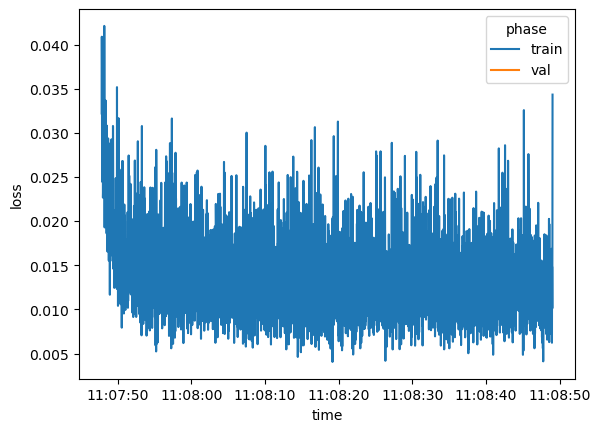

In [21]:
loss.loc[loss["phase"]=="test", "phase"] = "val"
sns.lineplot(data=loss, x='time', y='loss', hue='phase')


In [22]:
from biological_fuzzy_logic_networks.utils import MSE_loss
input_nodes = [k for k in input_test.keys()]
test_ground_truth = test_data.copy()
losses = []
with torch.no_grad():
    # Instantiate the model
    my_model.initialise_random_truth_and_output(
        len(test_ground_truth[input_nodes[0]])
    )
    my_model.set_network_ground_truth(ground_truth=test_ground_truth)
    # Simulation
    my_model.sequential_update(input_nodes, test_inhibitors)
    # Get the predictions
    predictions = my_model.output_states
    test_loss = MSE_loss(
        predictions=predictions, ground_truth=test_ground_truth
    )

    

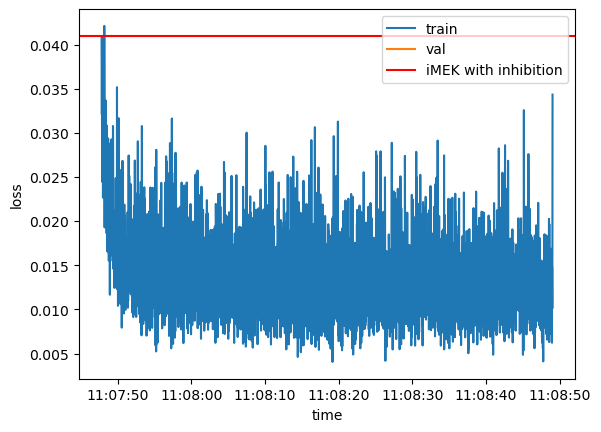

In [23]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')
plt.axhline(y=test_loss, c="red", label="iMEK with inhibition")
plt.legend()